Először importáljunk a könyvtárakat

In [1]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import time

Ezután importáljuk be az adathalmazunkat és osszuk fel a tanító- és teszthalmazokra. Az összes számítást a tanító halmazon fogjuk végezni.

In [2]:
X,y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

A load_diabetes egy beépített függvény a scikit-learn könyvtárban.

test_size=0.33: Ez azt jelzi, hogy az adatok 33%-a a teszthalmazba kerül, míg a maradék 67% a tanítóhalmazba.

random_state=42: Ezzel az inicializált generátorral az adatok véletlenszerűen kerülnek szétosztásra, de azonos kezdeti állapot mellett minden futtatáskor ugyanazt az elosztást kapjuk.

A max_features azt határozza meg, hogy a véletlen erdő (Random Forest) modell melyik részhalmazát használja a bemeneti jellemzőkből az egyes döntési fák építésekor.

Az n_estimators azt határozza meg, hogy hány döntési fát használjunk a véletlen erdő modellben.

# Greedy algoritmus

In [3]:
greedy_start_time = time.time()

greedy_best_score = -float('inf')  # Kezdeti legjobb pontszám
greedy_best_params = None  # Kezdeti legjobb paraméterek

n_estimators_values = []
max_features_values = []
mean_test_scores = []

for n_estimators in range(5, 100, 5):
    for max_features in np.arange(0.1, 1.0, 0.05):
        # Modell létrehozása az adott paraméterekkel
        model = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, random_state=0)
        
        # Keresztvalidáció és pontszám kiszámítása
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring="r2", n_jobs=-1)
        mean_score = np.mean(scores)
        
        # Save values for plotting
        n_estimators_values.append(n_estimators)
        max_features_values.append(max_features)
        mean_test_scores.append(mean_score)

        # Ellenőrzés, hogy a pontszám jobb-e a jelenleginél
        if mean_score > greedy_best_score:
            greedy_best_score = mean_score
            greedy_best_params = {'n_estimators': n_estimators, 'max_features': max_features}

greedy_elapsed_time = time.time() - greedy_start_time

print(f"Legjobb hiperparaméterek kombinációja: {greedy_best_params}")
print(f"Legjobb pontszám: {greedy_best_score}")
print(f"Idő: {greedy_elapsed_time} s")

Legjobb hiperparaméterek kombinációja: {'n_estimators': 90, 'max_features': 0.5000000000000001}
Legjobb pontszám: 0.41499526025667494
Idő: 21.085965871810913 s


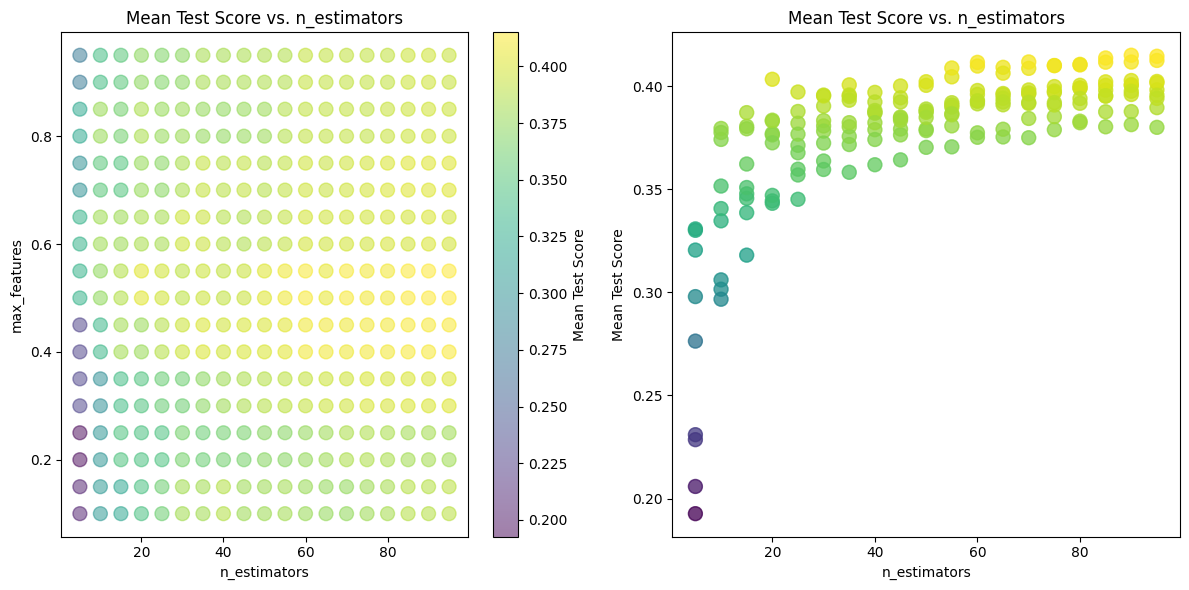

In [4]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(n_estimators_values, max_features_values, c=mean_test_scores, cmap='viridis', marker='o', s=100, alpha=0.5)
plt.colorbar(label='Mean Test Score')
plt.xlabel('n_estimators')
plt.ylabel('max_features')
plt.title('Mean Test Score vs. n_estimators')

plt.subplot(1, 2, 2)
plt.scatter(n_estimators_values, mean_test_scores, c=mean_test_scores, cmap='viridis', marker='o', s=100, alpha=0.5)
plt.xlabel('n_estimators')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score vs. n_estimators')

plt.tight_layout()
plt.show()

Most kezdjük el a rácskeresést. 
Bemenetként megadjuk a regresszorunkat, amit optimalizálni szeretnénk, a keresztező validációk számát, valamint a legjobb hiperparaméterértékek kiválasztásakor figyelembe venni kívánt pontozási metrikust. 
Az utolsó argumentum egy lista az egyes hiperparaméterek értékeinek felderítésére. A GridSearchCV létrehozza az összes lehetséges kombinációt.

Tegyük fel, hogy a n_estimators hiperparamétert 5-től 100-ig szeretnénk beállítani 5 lépésenként, és a max_features hiperparamétert 0.1-től 1.0-ig 0.05 lépésenként. 
Azon kombinációkat keresjük, amelyek a 5-körös keresztező validációban az R2 érték átlagát maximálisra növelik.

Véletlenszerű erdei regresszor.

A véletlenszerű erdő egy metabecslő, amely számos osztályozó döntési fát illeszt az adatkészlet különböző almintáira, és átlagolást használ a prediktív pontosság javítására és a túlillesztés szabályozására.

Amint elindítjuk a rácskeresést, a Python minden lehetséges érték kombinációt kipróbál a megadott listákban, és kiválasztja a legmagasabb pontszámot kapó kombinációt.

Ez a folyamat eltarthat egy ideig, mivel a rács nagy.

# Grid search algoritmus

In [5]:
grid_start_time = time.time()

grid_search = GridSearchCV(RandomForestRegressor(random_state=0),
                           {
                              'n_estimators': np.arange(5, 100, 5),
                              'max_features': np.arange(0.1, 1.0, 0.05),
                            },
                            cv=5, scoring="r2", verbose=1, n_jobs=-1
                           )
grid_search.fit(X_train, y_train)

grid_elapsed_time = time.time() - grid_start_time

print("Legjobb hiperparaméterek kombinációja:")
print(grid_search.best_params_)
print("Legjobb pontszám:")
print(grid_search.best_score_)
print(f"Idő: {grid_elapsed_time} s")

Fitting 5 folds for each of 342 candidates, totalling 1710 fits
Legjobb hiperparaméterek kombinációja:
{'max_features': 0.5000000000000001, 'n_estimators': 90}
Legjobb pontszám:
0.41499526025667494
Idő: 9.430883646011353 s


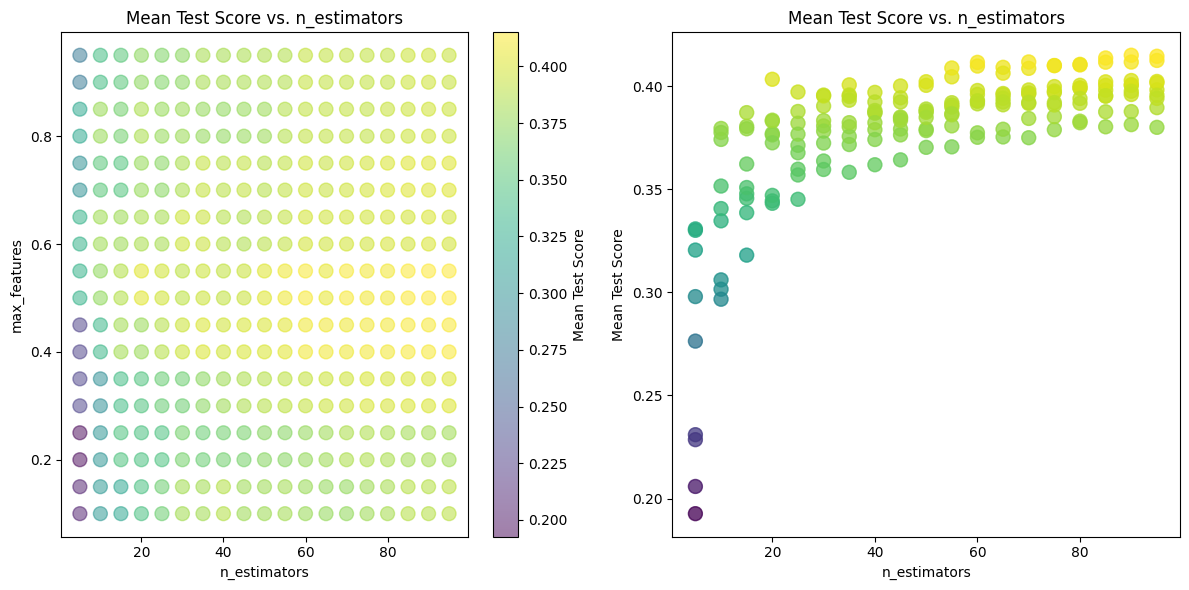

In [6]:
results = grid_search.cv_results_
n_estimators = results['param_n_estimators']
max_features = results['param_max_features']
mean_test_score = results['mean_test_score']


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(n_estimators, max_features, c=mean_test_score, cmap='viridis', marker='o', s=100, alpha=0.5)
plt.colorbar(label='Mean Test Score')
plt.xlabel('n_estimators')
plt.ylabel('max_features')
plt.title('Mean Test Score vs. n_estimators')

plt.subplot(1, 2, 2)
plt.scatter(n_estimators, mean_test_score, c=mean_test_score, cmap='viridis', marker='o', s=100, alpha=0.5)
plt.xlabel('n_estimators')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score vs. n_estimators')

plt.tight_layout()
plt.show()

Most csak 250 illesztést (5 illesztés 50 iterációval) dolgozunk, és a folyamat csak pár másodpercet vesz igénybe az eredmény eléréséhez.

# Random search algoritmus

In [7]:
random_start_time = time.time()

random_search = RandomizedSearchCV(RandomForestRegressor(random_state=0),
                           {
                              'n_estimators': np.arange(5, 100, 5),
                              'max_features': np.arange(0.1, 1.0, 0.05),
                            },
                            cv=5, scoring="r2", verbose=1, n_jobs=-1,
                            n_iter=50, random_state=0
                           )
random_search.fit(X_train, y_train)

random_elapsed_time = time.time() - random_start_time

print("Legjobb hiperparaméterek kombinációja:")
print(random_search.best_params_)
print("Legjobb pontszám:")
print(random_search.best_score_)
print(f"Idő: {random_elapsed_time} s")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Legjobb hiperparaméterek kombinációja:
{'n_estimators': 95, 'max_features': 0.5500000000000002}
Legjobb pontszám:
0.41450360960321453
Idő: 1.7243003845214844 s


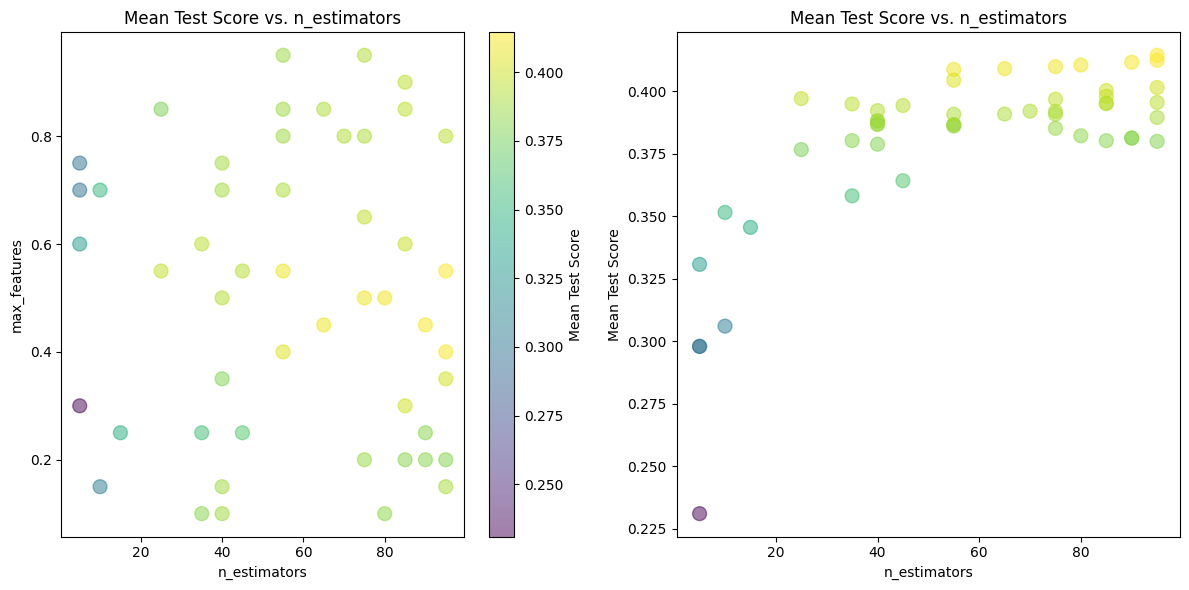

In [8]:
results = random_search.cv_results_
n_estimators = results['param_n_estimators']
max_features = results['param_max_features']
mean_test_score = results['mean_test_score']


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(n_estimators, max_features, c=mean_test_score, cmap='viridis', marker='o', s=100, alpha=0.5)
plt.colorbar(label='Mean Test Score')
plt.xlabel('n_estimators')
plt.ylabel('max_features')
plt.title('Mean Test Score vs. n_estimators')

plt.subplot(1, 2, 2)
plt.scatter(n_estimators, mean_test_score, c=mean_test_score, cmap='viridis', marker='o', s=100, alpha=0.5)
plt.xlabel('n_estimators')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Score vs. n_estimators')

plt.tight_layout()
plt.show()

Láthatjuk, hogy az eredmény nagyon hasonló a rácskeresés által talált eredményhez, de a véletlen keresés sokkal csökkentette a számítási időt.

Azt gondolom, hogy a három algoritmus közül a véletlen keresés nagyon hasznos, mert gyorsabb, és mivel nem éri el a rács legjobb pontját, elkerüli az overfittinget, és jobban képes általánosítani. 

Azonban kis rácsok esetén (azaz kevesebb, mint 200 pont) javaslom a rácskeresés használatát, ha a tanítási fázis nem túl lassú. 

Általános célú esetekben a véletlen keresés növelheti a tanítási sebességet és elérhet egy elfogadható jó megoldást a modelünkhöz.

Az "overfitting" (túltanítás) egy olyan fogalom a gépi tanulásban, amely akkor jelentkezik, amikor egy modell túl jól alkalmazkodik a tanítóadathoz, és emiatt nem képes általánosítani a tanítóadaton kívüli adatokra.

Az overfitting során a modell túlságosan bonyolultsá válik, és olyan zajt és véletlen változásokat is megtanul a tanítóadatban, amelyek nem relevánsak az általánosításhoz.